# CNN Version 2 - CIFAR-10 dataset

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f"GPU's available: {gpus}")
    print("Using first GPU")
    try:
      # Use first GPU
      tf.config.set_visible_devices(gpus[0], 'GPU')
      logical_devices = tf.config.list_logical_devices('GPU')
      assert len(logical_devices) == 1
    except Exception as e:
      # Invalid device or cannot modify virtual devices once initialized.
      print(f"Error while loading GPU: {e}")
else:
    print("GPU's not available")

GPU's available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Using first GPU


## Load Dataset

In [3]:
# Use the CIFAR-10 dataset from keras for easier retrieval
# (However we are going to use the raw CIFAR-10 dataset and do the splitting ourselves)
(X_train_keras, y_train_keras), (X_test_keras, y_test_keras) = cifar10.load_data()
X = np.concatenate((X_train_keras, X_test_keras), axis=0)
y = np.concatenate((y_train_keras, y_test_keras), axis=0)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Data Preprocessing

In [4]:
X_scaled = X / 255.0
y_cat = to_categorical(y, 10)

## Training-Validation-Test Split

In [5]:
# 80-10-10 train-val-test split (48000, 6000, 6000)
X_train, X_remain, y_train, y_remain = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42, stratify=y_cat)
X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=42, stratify=y_remain)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (48000, 32, 32, 3)
y_train shape: (48000, 10)
X_val shape: (6000, 32, 32, 3)
y_val shape: (6000, 10)
X_test shape: (6000, 32, 32, 3)
y_test shape: (6000, 10)


## Model Architecture

In [6]:
model_name = "cnn_version_2"
model = Sequential()

# First block of Conv2D layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

# Second block of Conv2D layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

# Third block of Conv2D layers (to increase depth)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))

# Global Average Pooling to reduce number of parameters
model.add(GlobalAveragePooling2D())

# Fully connected layer with reduced dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 324,394 (1.24 MB)

 Trainable params: 323,498 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

## Train Model

In [8]:
loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate=0.0009)
metrics = ['accuracy']

model.compile(loss = loss, optimizer = opt, metrics = metrics)

In [9]:
r = model.fit(X_train, y_train, batch_size = 64, epochs = 50, validation_data = (X_val, y_val))

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.3843 - loss: 1.7070 - val_accuracy: 0.6230 - val_loss: 1.0467
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6163 - loss: 1.0889 - val_accuracy: 0.6678 - val_loss: 0.9181
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6749 - loss: 0.9224 - val_accuracy: 0.6593 - val_loss: 1.0353
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7263 - loss: 0.7952 - val_accuracy: 0.7597 - val_loss: 0.7046
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7567 - loss: 0.7175 - val_accuracy: 0.7830 - val_loss: 0.6220
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7716 - loss: 0.6642 - val_accuracy: 0.7957 - val_loss: 0.6034
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7929 - loss: 0.6127 - val_accuracy: 0.7610 - val_loss: 0.6954
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7972 - loss: 0.5894 - val_accuracy: 

## Save Model

In [10]:
model.save(f'{model_name}.h5')

## Model Performance

### Acuraccy and Loss Evaluation

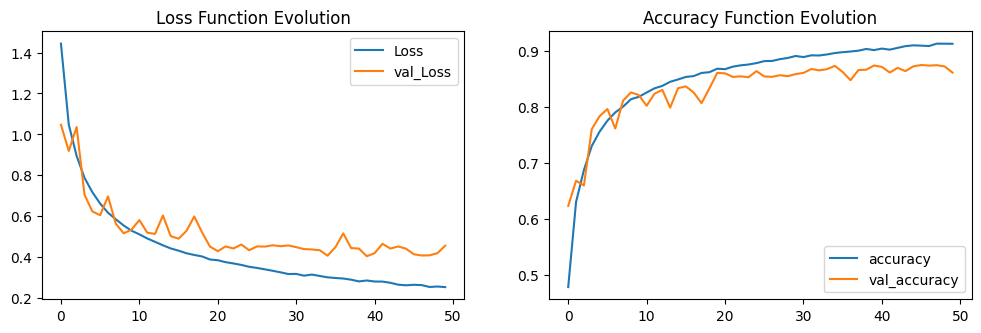

In [11]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

### Accuracy with the Testing Data

In [12]:
train_evaluation = model.evaluate(X_train, y_train, return_dict=True)
print(f'Training Accuracy : {train_evaluation["accuracy"] * 100:.2f}%')
val_evaluation = model.evaluate(X_val, y_val, return_dict=True)
print(f'Validation Accuracy : {val_evaluation["accuracy"] * 100:.2f}%')
test_evaluation = model.evaluate(X_test, y_test, return_dict=True)
print(f'Test Accuracy : {test_evaluation["accuracy"] * 100:.2f}%')

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9605 - loss: 0.1166
Training Accuracy : 96.03%
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8608 - loss: 0.4588
Validation Accuracy : 86.07%
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8631 - loss: 0.4396
Test Accuracy : 85.92%


### Confusion Matrix

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<Axes: >

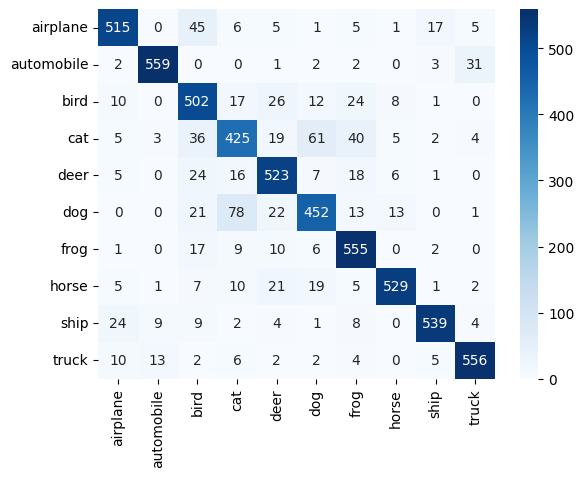

In [13]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_predictions = model.predict(X_test)
y_pred = np.argmax(y_predictions, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)
sns.heatmap(
    confusion_matrix(y_test_true_labels, y_pred), annot=True, fmt='d', cmap='Blues',
    xticklabels=class_labels, yticklabels=class_labels)

### Classification Report

In [14]:
print(classification_report(y_test_true_labels, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       600
           1       0.96      0.93      0.94       600
           2       0.76      0.84      0.79       600
           3       0.75      0.71      0.73       600
           4       0.83      0.87      0.85       600
           5       0.80      0.75      0.78       600
           6       0.82      0.93      0.87       600
           7       0.94      0.88      0.91       600
           8       0.94      0.90      0.92       600
           9       0.92      0.93      0.92       600

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



### ROC Curve and AUC for each class

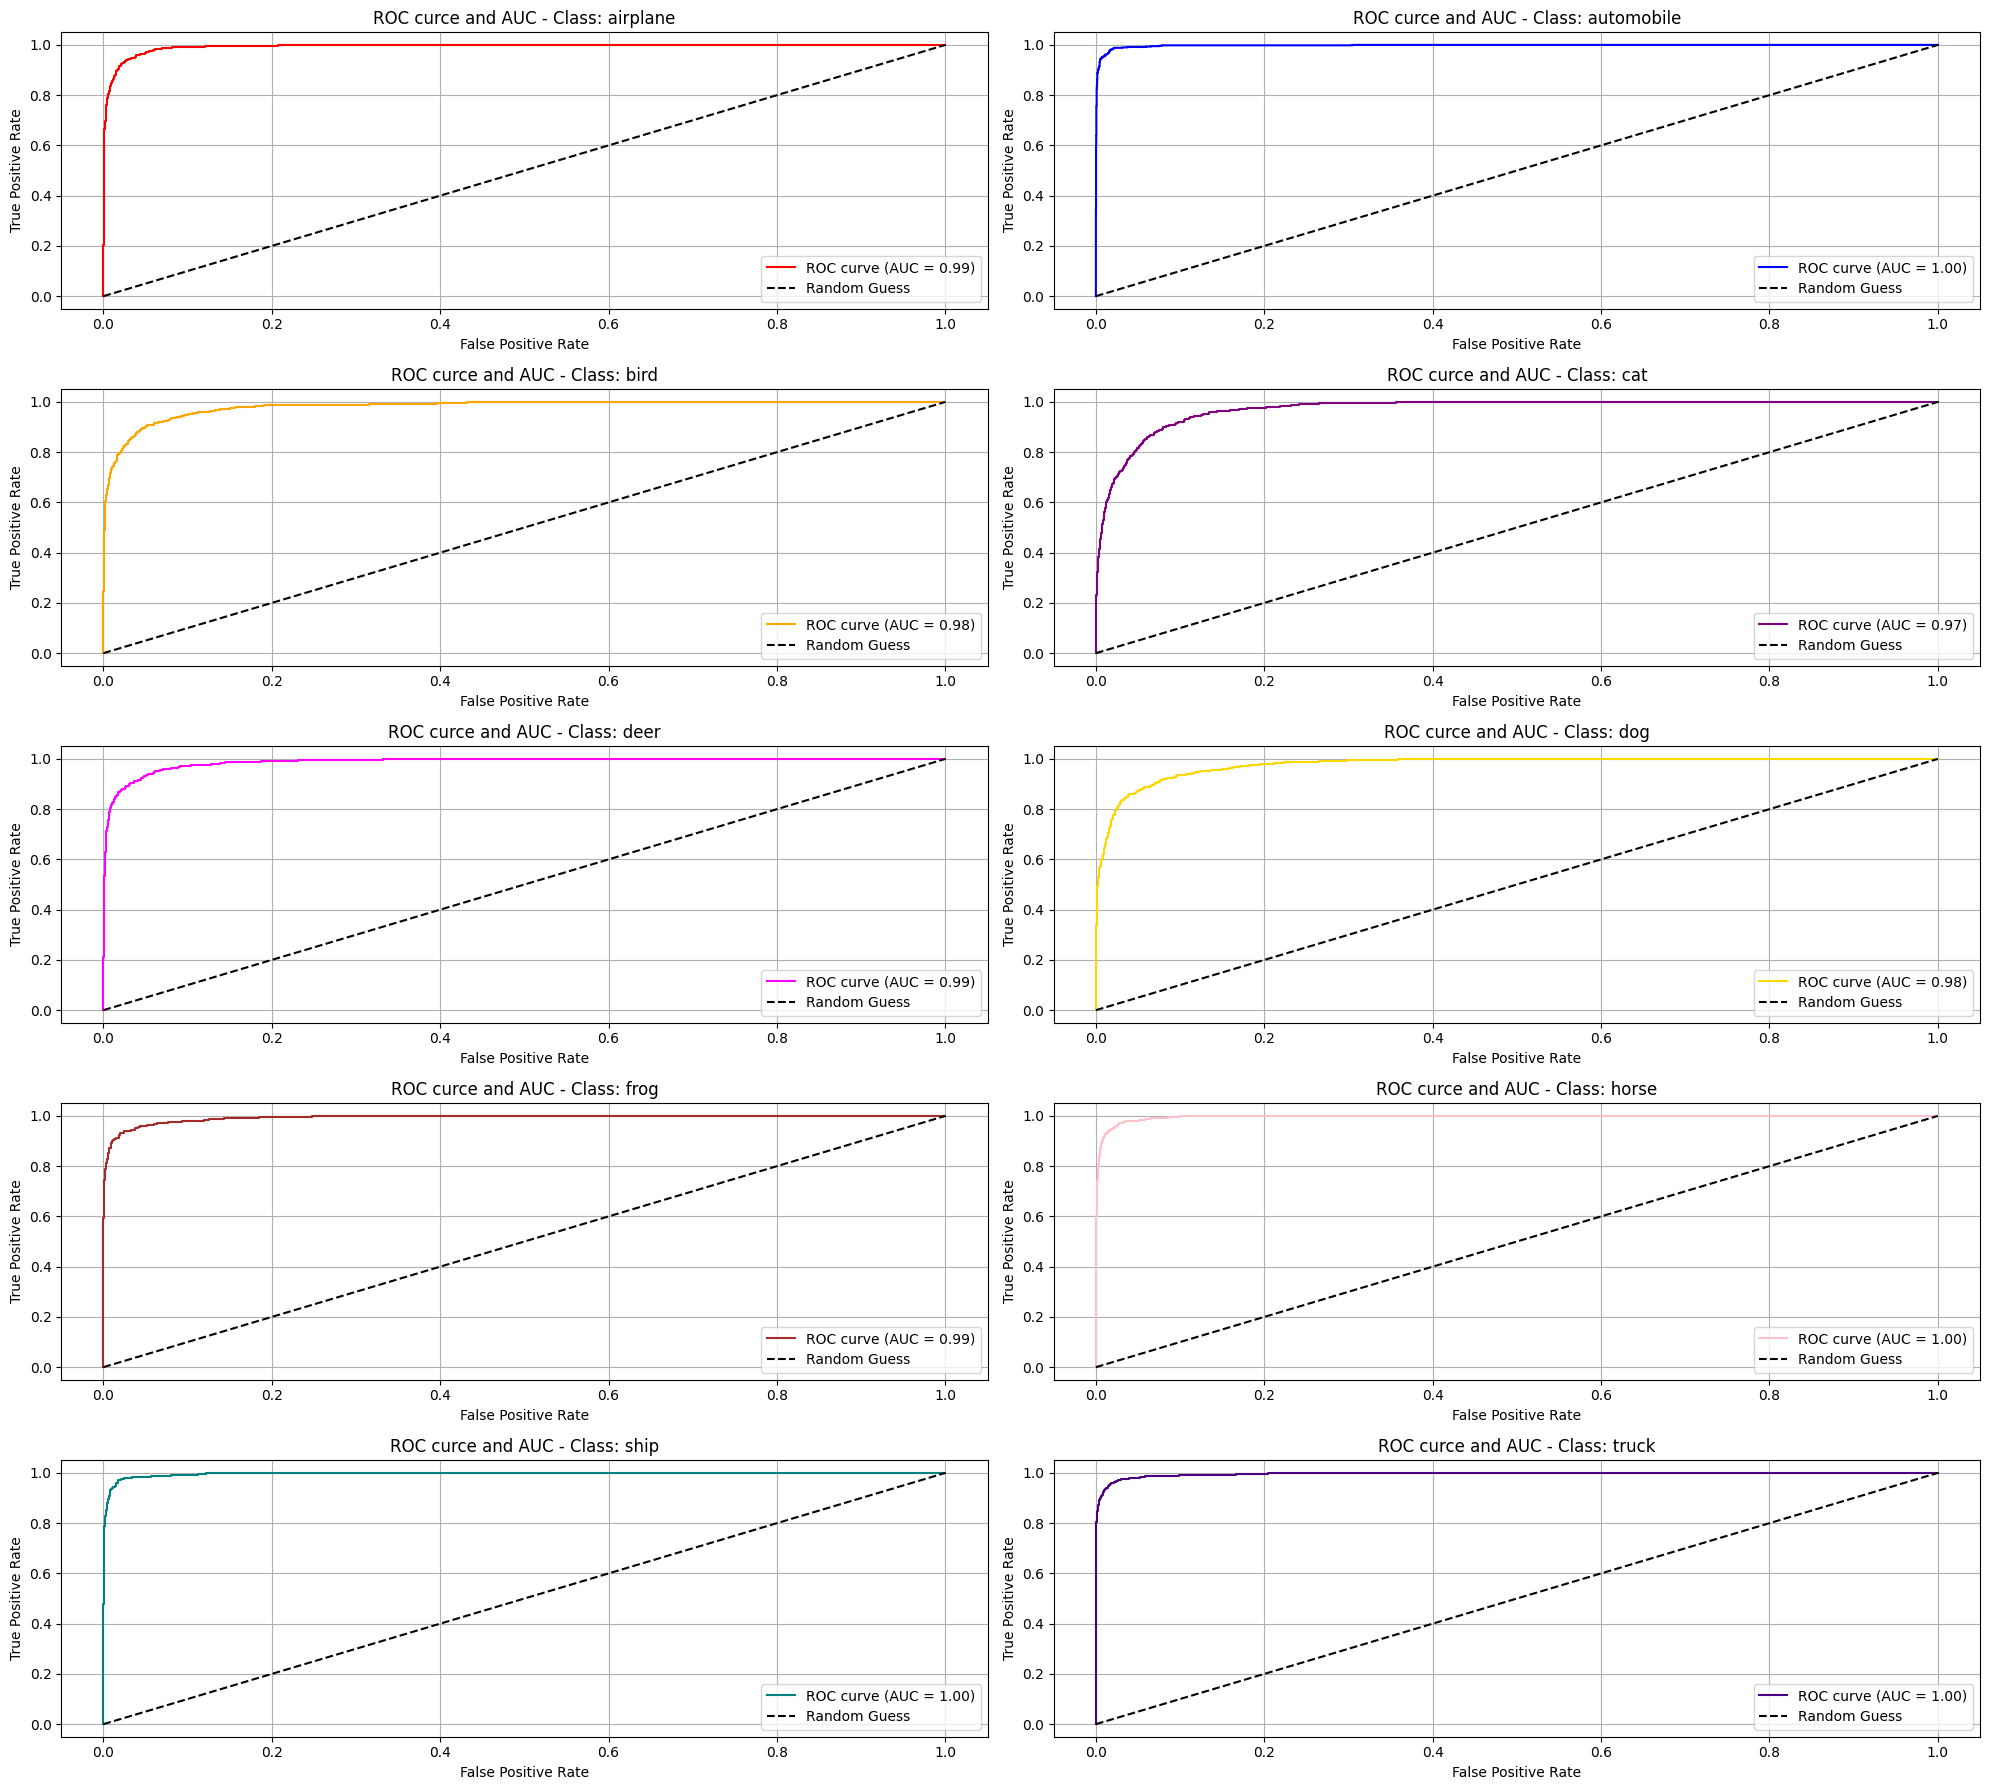

In [15]:
n_classes = len(class_labels)
class_colors = ['red', 'blue', 'orange', 'purple', 'magenta', 'gold', 'brown', 'pink', 'teal', 'indigo']
fpr = {}
tpr = {}
roc_auc = {}

fig, axes = plt.subplots(5, 2, figsize=(20, 18))
axes = axes.ravel()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes[i].plot(fpr[i], tpr[i], label=f'ROC curve (AUC = {roc_auc[i]:.2f})', color=class_colors[i])
    axes[i].plot([0, 1], [0, 1], 'k--', label='Random Guess')
    axes[i].set_title(f'ROC curce and AUC - Class: {class_labels[i]}')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].legend(loc='lower right')
    axes[i].grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()